## Install Packages

In [ ]:
pip install talos

## Importing Libraries  

In [8]:
## Importing the libraries
%matplotlib inline
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sys
from numpy import load
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications import Xception
from keras.applications import NASNetLarge
from keras.applications import DenseNet201
from keras.applications import InceptionResNetV2

## Data Building

In [ ]:
## Reading the DataFrame
df2=pd.read_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Spt_Trans/df.csv')
#Aggregate, groupby and join
df3=df2.groupby(['x','y']).agg('gene_name').apply(lambda x:" ".join(list(set(x)))).reset_index()
#Save File
df3.to_csv('genes_file.csv') 

In [ ]:
## Processing the Dataframe
df3 = pd.read_csv('genes_file.csv')
df3=df3.drop(columns=['Unnamed: 0'])
df3['Sno'] = np.arange(len(df3))+1
df3['Sno'] = df3['Sno'].astype(str)
df3['Sno']= df3['Sno'].str.zfill(4) + 'img'
#link_to_img=df3[['x','y','Sno']]
#link_to_img.to_csv('link_to_img.csv')

In [ ]:
df3=df3.drop(columns=['x','y'])
df3.head(5)

In [10]:
df5=pd.read_csv('Gene_list_df5.csv')
df5=df5.drop(columns=['Unnamed: 0'])
df5.tail()

,gene_name,Sno
3793,NIBAN3 AC110285.2 PTPRC SLC26A11 SLC19A2 MESD ...,3794img
3794,AC110285.2 USP28 SLC19A2 MESD MAPK1IP1L SPTLC2...,3795img
3795,AC015871.1 SLC26A11 SLC36A4 SLC19A2 MESD MOB4 ...,3796img
3796,AC015871.1 AC110285.2 PTPRC USP28 SLC19A2 STK3...,3797img
3797,AC015871.1 PARM1 PTPRC SLC19A2 STK35 MESD MAPK...,3798img


## Generating Images

In [6]:
Vals=pd.read_csv('link_to_img.csv')
Vals['left']=Vals['x']-70
Vals['up']=Vals['y']-70
Vals['right']=Vals['x']+70
Vals['down']=Vals['y']+70
Vals=Vals.values
x_offset = Vals[:,4] 
Y_offset = Vals[:,5]
width = Vals[:,6] 
height = Vals[:,7]
box = (Y_offset, x_offset, height, width)

In [ ]:
import PIL
from PIL import Image
PIL.Image.MAX_IMAGE_PIXELS = 933120000
image=Image.open('D:/onkar/Projects/Project_Spt.Transcriptomics/Input_files/V1_Breast_Cancer_Block_A_Section_1_image.tif')
#Transpose
numpy_array = np.array(box)
transpose = numpy_array.T
box = transpose.tolist()
box
#Save Images
imgno=1
for i in range(0,len(box)):
    crop = image.crop(box[i])
    crop.save(str(imgno).zfill(4)+'img.tif')
    imgno=imgno+1

In [ ]:
#Sharpened Images
from PIL import ImageFilter
from PIL import Image
import glob
imgnoo=1
for img in glob.glob("C:/Users/Onkar/Untitled Folder/Trainimg/*.tif"):
    img=Image.open(img)
    sharpened1 = img.filter(ImageFilter.SHARPEN)
    sharpened2 = sharpened1.filter(ImageFilter.SHARPEN)
    sharpened2.save(str(imgnoo).zfill(4)+'img.tif')
    imgnoo=imgnoo+1

In [ ]:
#Smooth Images
from PIL import ImageFilter
from PIL import Image
import glob
imgnoo=1
for img in glob.glob("C:/Users/Onkar/Untitled Folder/Trainimg/*.tif"):
    img=Image.open(img)
    smoothenedImage = img.filter(ImageFilter.SMOOTH)
    moreSmoothenedImage = img.filter(ImageFilter.SMOOTH_MORE)
    moreSmoothenedImage.save(str(imgnoo).zfill(4)+'img.tif')
    imgnoo=imgnoo+1

In [ ]:
#Resize Images -> Resnet
from PIL import ImageFilter
from PIL import Image
import glob
imgnoo=1
for img in glob.glob("C:/Users/Onkar/Untitled Folder/Trainimg/*.tif"):
    img=Image.open(img)
    resized=img.resize((331,331))
    resized.save(str(imgnoo).zfill(4)+'img.tif')
    imgnoo=imgnoo+1

## One hot encode and Mapping X and Y

In [13]:
# create a mapping of tags to integers given the loaded mapping file
def create_tag_mapping(df3):
    # create a set of all known tags
    labels = set()
    for i in range(len(df3)):
        # convert spaced separated tags into an array of tags
        gene_name = df3['gene_name'][i].split(' ')
        # add tags to the set of known labels
        labels.update(gene_name)
    # convert set of labels to a list to list
    labels = list(labels)
    # order set alphabetically
    labels.sort()
    # dict that maps labels to integers, and the reverse
    labels_map = {labels[i]:i for i in range(len(labels))}
    inv_labels_map = {i:labels[i] for i in range(len(labels))}
    return labels_map, inv_labels_map
# create a mapping of filename to tags
def create_file_mapping(df3):
    mapping = dict()
    for i in range(len(df3)):
        name, gene_name = df3['Sno'][i], df3['gene_name'][i]
        mapping[name] = gene_name.split(' ')
    return mapping
# create a one hot encoding for one list of tags
def one_hot_encode(gene_name, mapping):
    # create empty vector
    encoding = zeros(len(mapping), dtype='uint8')
    # mark 1 for each tag in the vector
    for tag in gene_name:
        encoding[mapping[tag]] = 1
    return encoding
def load_dataset(path, file_mapping, tag_mapping):
    photos, targets = list(), list()
    # enumerate files in the directory
    for filename in listdir(folder):
        # load image
        photo = load_img(path + filename, target_size=(140,140))
        # convert to numpy array
        photo = img_to_array(photo, dtype='uint8')
        # get tags
        gene_name = file_mapping[filename[:-4]]
        # one hot encode tags
        target = one_hot_encode(gene_name, tag_mapping)
        # store
        photos.append(photo)
        targets.append(target)
    X = asarray(photos, dtype='uint8')
    y = asarray(targets, dtype='uint8')
    return X, y

In [14]:
# load and prepare planet dataset and save to file
from os import listdir
from numpy import zeros
from numpy import asarray
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
mapping_csv = df5
# create a mapping of tags to integers
tag_mapping, _ = create_tag_mapping(mapping_csv)
# create a mapping of filenames to tag lists
file_mapping = create_file_mapping(mapping_csv)
folder = 'C:/Users/Onkar/UntitledFolder/Trainimg_breast2/'
X, y = load_dataset(folder, file_mapping, tag_mapping)
print(X.shape, y.shape)

'''
# save both arrays to one file in compressed format
#savez_compressed('planet_data.npz', X, y)
#X = np.delete(X, slice(3551,3798), axis=0)
#y = np.delete(y, slice(3551,3798), axis=0)
#file_mapping

arr2D1 = np.delete(X, slice(1,46), axis=0)
arr2Dy1 = np.delete(y, slice(1,46), axis=0)
print(arr2D1.shape, arr2Dy1.shape)

X = np.delete(arr2D1, slice(3049,3753), axis=0)
y = np.delete(arr2Dy1, slice(3049,3753), axis=0)
print(X.shape, y.shape)
'''

(3798, 140, 140, 3) (3798, 24916)


"\n# save both arrays to one file in compressed format\n#savez_compressed('planet_data.npz', X, y)\n#X = np.delete(X, slice(3551,3798), axis=0)\n#y = np.delete(y, slice(3551,3798), axis=0)\n#file_mapping\n\narr2D1 = np.delete(X, slice(1,46), axis=0)\narr2Dy1 = np.delete(y, slice(1,46), axis=0)\nprint(arr2D1.shape, arr2Dy1.shape)\n\nX = np.delete(arr2D1, slice(3049,3753), axis=0)\ny = np.delete(arr2Dy1, slice(3049,3753), axis=0)\nprint(X.shape, y.shape)\n"

In [ ]:
#file_mapping

## Uploading the data for Model Building

In [21]:
from numpy import savez_compressed
indices = list(np.where((y.sum(axis=0)<3600)))
a = np.delete(y, indices, 1)
#a1 = a.sum(axis=0)/3407
#b= a*a1
#b
X=X/255
#savez_compressed('planet_data1.npz', X, a)
#X=X/255
savez_compressed('planet_data_trail.npz', X, a)
a.shape

(3798, 335)

In [33]:
def load_dataset():
    # load dataset
    data = load('planet_data_trail.npz')
    X, y = data['arr_0'], data['arr_1']
    # separate into train and test datasets
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.20, random_state=1)
    return trainX, trainY, testX, testY
    print(trainX.shape, trainY.shape, testX.shape, testY.shape)

In [23]:
def fbeta(y_true, y_pred, beta=2):
    # clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate precision
    p = tp / (tp + fp + backend.epsilon())
    # calculate recall
    r = tp / (tp + fn + backend.epsilon())
    # calculate fbeta, averaged across each class
    bb = beta ** 2
    #bb1 = (beta-1) ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    #fbeta_score1 = backend.mean((1 + bb1) * (p * r) / (bb1 * p + r + backend.epsilon()))
    return fbeta_score #, fbeta_score1

## Removing Gene Names from the tags for low counts 

In [24]:
genes_left=_
for i in indices[0]:
    if i in genes_left.keys():
        del genes_left[i]

## Correlation Between Genes

In [25]:
a1=pd.DataFrame(a)

In [26]:
genes=genes_left.values()
list(genes)
a1.columns=genes
a1['Sno'] = df5['Sno']
#a1['Sno'] = np.arange(len(df5))+1
#a1['Sno'] = a1['Sno'].astype(str)
#a1['Sno']= a1['Sno'].str.zfill(4) + 'img'
a1=a1.set_index('Sno')
#a1 = a1.drop(labels='Sno', axis=1)
a1.head()

,ACTB,ACTG1,ADAR,ADIRF,AEBP1,AGR2,ANAPC11,APOC1,APOE,APRT,...,UBC,UBL5,UQCR11,UQCRB,UQCRQ,VIM,VMP1,XBP1,YWHAZ,ZNF703
Sno,,,,,,,,,,,,,,,,,,,,,
0001img,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,1,1,1,1,1
0002img,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0003img,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0004img,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0005img,1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
from numpy import savez_compressed
from numpy import asarray
from numpy import save
col_Trues=a1.columns.to_numpy()
col_Trues=asarray(col_Trues)
save('col_Trues.npy', col_Trues)

In [ ]:
#Highly expressed genes
corr_matrix=a1.corr()
#corr_matrix.to_csv('Correlation.csv')
import seaborn as sb
sb.heatmap(corr_matrix, vmin = .75, square = True)
plt.show()
#Kfold

In [ ]:
import plotly.graph_objects as go
from matplotlib.pyplot import figure
figure(figsize=(20,20))
a1_sum = a1.sum()
a1_sum.plot(kind='barh')
#fig=go.Figure(data=go.Bar(a1_sum.plot()))
#fig.show()
'''
import seaborn as sns
categories = list(a1.columns.values)
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(categories, a1.iloc[:,0:].sum().values)
plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)
#adding the text labels
rects = ax.patches
labels = a1.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()'''

## Model Building

## Basic CNN

In [ ]:
# define cnn model
from keras.layers import BatchNormalization
def define_model(in_shape=(190,314, 3), out_shape=4316):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Fbeta')
    pyplot.plot(history.history['fbeta'], color='blue', label='train')
    pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.show()
    

In [ ]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# baseline model with dropout on the planet dataset
import sys
from numpy import load
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
#from keras.layers import Merge
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications import Xception
from keras.applications import NASNetLarge
from keras.applications import DenseNet201
from keras.applications import InceptionResNetV2
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = datagen.flow(trainX, trainY, batch_size=128)
    test_it = datagen.flow(testX, testY, batch_size=128)
    # define model
    model = define_model()
    # fit model
    history = model.fit(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=1, verbose=1)
    # evaluate model
    loss, fbeta = model.evaluate(test_it, steps=len(test_it), verbose=1)
    print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
    # learning curves
    #summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

## InceptionV3

Epoch 1/10
48/48 [==============================] - 55s 1s/step - loss: 0.2777 - fbeta: 0.9043 - val_loss: 0.1058 - val_fbeta: 0.9949
Epoch 2/10
48/48 [==============================] - 62s 1s/step - loss: 0.1122 - fbeta: 0.9952 - val_loss: 0.1016 - val_fbeta: 0.9948
Epoch 3/10
48/48 [==============================] - 62s 1s/step - loss: 0.1072 - fbeta: 0.9954 - val_loss: 0.1010 - val_fbeta: 0.9949
Epoch 4/10
48/48 [==============================] - 61s 1s/step - loss: 0.1053 - fbeta: 0.9955 - val_loss: 0.1040 - val_fbeta: 0.9949
Epoch 5/10
48/48 [==============================] - 60s 1s/step - loss: 0.1074 - fbeta: 0.9956 - val_loss: 0.1069 - val_fbeta: 0.9949
Epoch 6/10
48/48 [==============================] - 71s 1s/step - loss: 0.1068 - fbeta: 0.9955 - val_loss: 0.1055 - val_fbeta: 0.9949
Epoch 7/10
48/48 [==============================] - 78s 2s/step - loss: 0.1050 - fbeta: 0.9955 - val_loss: 0.1048 - val_fbeta: 0.9948
Epoch 8/10
48/48 [==============================] - 77s 2s/ste

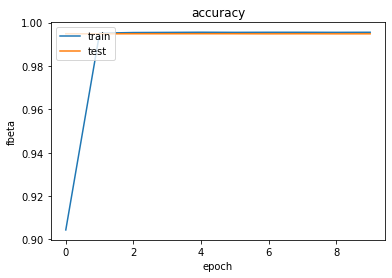

In [34]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sys
from numpy import load
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
#from keras.layers import Merge
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import regularizers
from keras.applications import Xception
from keras.applications import NASNetLarge
from keras.applications import DenseNet201
from keras.applications import InceptionResNetV2
# define cnn model
def define_model(in_shape=(140,140,3), out_shape=335):
    # load model
    model = InceptionV3(include_top=False, input_shape=in_shape)
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False  
    # allow last vgg block to be trainable
    #model.get_layer('block5_conv1').trainable = True
    #model.get_layer('block5_conv2').trainable = True
    #model.get_layer('block5_conv3').trainable = True
    #model.get_layer('block5_pool').trainable = True
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(32, activation='relu', kernel_initializer='random_normal',kernel_regularizer =regularizers.l1_l2( l1=1e-7,l2=1e-7))(flat1)#
    #,kernel_regularizer =tf.keras.regularizers.l1( l=0.01)
    #batch=BatchNormalization()(class1)
    #max_pool=MaxPooling2D()(batch)
    #model.add(Dense(units=128,activation = 'relu'))
    drop = Dropout(0.35)(class1)
    output = Dense(out_shape, activation='sigmoid')(drop)
    # dfine new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    #opt = optimizer.ADAM
    opt = SGD(lr=0.2, momentum=0.9,decay=1e-6)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics = fbeta)
    return model
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    # summarize history for loss
    plt.plot(history.history['fbeta'])
    plt.plot(history.history['val_fbeta'])
    plt.title('accuracy')
    plt.ylabel('fbeta')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()    
    
    
    # load dataset
trainX, trainY, testX, testY = load_dataset()
# create data generator
train_datagen = ImageDataGenerator(rescale=1./255,featurewise_center=True, horizontal_flip=True, vertical_flip=True, rotation_range=90)
test_datagen = ImageDataGenerator(rescale=1./255,featurewise_center=True)
    # specify imagenet mean values for centering
    #train_datagen.mean = [123.68, 116.779, 103.939]
    #test_datagen.mean = [123.68, 116.779, 103.939]
    # prepare iterators
train_datagen.fit(trainX)
test_datagen.fit(testX)
train_it = train_datagen.flow(trainX, trainY, batch_size=64)
test_it = test_datagen.flow(testX, testY, batch_size=64)
    # define model
model = define_model()
    # fit model
history = model.fit(train_it, steps_per_epoch=len(train_it),
validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
    # evaluate model
loss, fbeta = model.evaluate(test_it, steps=len(test_it), verbose=1)
print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
    # learning curves
summarize_diagnostics(history)

## Xception

In [ ]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# baseline model with dropout on the planet dataset
import sys
from numpy import load
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
#from keras.layers import Merge
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import regularizers

from keras.applications import Xception
from keras.applications import NASNetLarge
from keras.applications import DenseNet201
from keras.applications import InceptionResNetV2
# define cnn model
def define_model(in_shape=(190,314, 3), out_shape=4316):
    # load model
    model = DenseNet201(include_top=False, input_shape=in_shape)
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = True
    # allow last vgg block to be trainable
    #model.get_layer('block5_conv1').trainable = True
    #model.get_layer('block5_conv2').trainable = True
    #model.get_layer('block5_conv3').trainable = True
    #model.get_layer('block5_pool').trainable = True
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(32, activation='relu', kernel_initializer='random_normal',kernel_regularizer =regularizers.l1_l2( l1=0.000000001,l2=0.000000001))(flat1)#
    #,kernel_regularizer =tf.keras.regularizers.l1( l=0.01)
    #batch=BatchNormalization()(class1)
    #max_pool=MaxPooling2D()(batch)
    #model.add(Dense(units=128,activation = 'relu'))
    drop = Dropout(0.2)(class1)
    output = Dense(out_shape, activation='sigmoid')(drop)
    # dfine new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    #opt = optimizer.ADAM
    opt = SGD(lr=0.7, momentum=0.5)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # create data generator
    train_datagen = ImageDataGenerator(featurewise_center=True, horizontal_flip=True, vertical_flip=True, rotation_range=90)
    test_datagen = ImageDataGenerator(featurewise_center=True)
    # specify imagenet mean values for centering
    #train_datagen.mean = [123.68, 116.779, 103.939]
    #test_datagen.mean = [123.68, 116.779, 103.939]
    # prepare iterators
    train_it = train_datagen.flow(trainX, trainY, batch_size=32)
    test_it = test_datagen.flow(testX, testY, batch_size=32)
    # define model
    model = define_model()
    # fit model
    history = model.fit(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=2, verbose=1)
    # evaluate model
    loss, fbeta = model.evaluate(test_it, steps=len(test_it), verbose=1)
    print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
    # learning curves
    summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

## InceptionResNetV2

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from keras import metrics
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sys
from numpy import load
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
#from keras.layers import Merge
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications import Xception
from keras.applications import NASNetLarge
from keras.applications import DenseNet201
from keras.applications import InceptionResNetV2
from tensorflow.keras import regularizers
from keras import backend as K
from keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.utils import plot_model
#from ann_visualizer.visualize import ann_viz
from keras.applications import InceptionResNetV2
def define_model(in_shape=(190,314, 3), out_shape=2065):
    # load model
    model = InceptionResNetV2(include_top=False, input_shape=in_shape)
    for layer in model.layers:
        layer.trainable = False
    # allow last vgg block to be trainable
    #model.get_layer('block5_conv1').trainable = True
    #model.get_layer('block5_conv2').trainable = True
    #model.get_layer('block5_conv3').trainable = True
    #model.get_layer('block5_pool').trainable = True
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(32, activation='relu', kernel_initializer='random_normal',kernel_regularizer =regularizers.l1_l2( l1=1e-8,l2=1e-8))(flat1)#
    #,kernel_regularizer =tf.keras.regularizers.l1( l=0.01)
    #batch=BatchNormalization()(class1)
    #max_pool=MaxPooling2D()(batch)
    #model.add(Dense(units=128,activation = 'relu'))
    drop = Dropout(0.15)(class1)
    output = Dense(out_shape, activation='sigmoid')(class1)
    # dfine new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    #opt = optimizer.ADAM
    opt = SGD(lr=0.5, momentum = 0.5)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    # summarize history for loss
    #plt.plot(history.history['fbeta'])
    #plt.plot(history.history['val_fbeta'])
    plt.plot(history.history['loss'], color='blue', label='loss')
    plt.plot(history.history['val_loss'], color='orange', label='val-loss')
    plt.plot(history.history['fbeta'], color='black', label='train-f2score')
    plt.plot(history.history['val_fbeta'], color='red', label='test-f2score')
    plt.title('model loss and fbeta')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test','train-f2score','test-f2score'], loc='upper left')
    plt.show()

# run the test harness for evaluating a model
#def run_test_harness():
    # load dataset
trainX1, trainY1, testX1, testY1 = load_dataset()
    # create data generator
train_datagen = ImageDataGenerator(featurewise_center=True, horizontal_flip=True, vertical_flip=True, rotation_range=90)
test_datagen = ImageDataGenerator(featurewise_center=True)

train_it = train_datagen.flow(trainX1, trainY1, batch_size=64)
test_it = test_datagen.flow(testX1, testY1, batch_size=64)
    # define model
model = define_model()
    # fit model
history = model.fit(train_it, steps_per_epoch=len(train_it),
validation_data=test_it, validation_steps=len(test_it), epochs=3, verbose=1)
    # evaluate model
loss, fbeta = model.evaluate(test_it, steps=len(test_it), verbose=1)
print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
    # learning curves
summarize_diagnostics(history)
    #ann_viz(history)

# entry point, run the test harness
#run_test_harness()

In [ ]:
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [n_epochs_cv],
    'dropout_rate': [0.0, 0.10, 0.20, 0.30],
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=n_cv)

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

## Save the Model

In [ ]:
from keras.models import load_model 
model.save("model.h5")
#loaded_model = load_model("model.h5") 
#loss, accuracy = loaded_model.evaluate(test_data, test_targets) 

## ROC-AUC

In [35]:
testY

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [36]:
predicted_vals = model.predict(test_it, steps=len(test_it))
predicted_vals

array([[0.9999571 , 0.9999421 , 0.95887464, ..., 0.9976542 , 0.99057984,
        0.99440145],
       [0.9999572 , 0.9999421 , 0.95888484, ..., 0.9976548 , 0.99058294,
        0.9944031 ],
       [0.9999572 , 0.9999422 , 0.95888364, ..., 0.9976548 , 0.9905823 ,
        0.994403  ],
       ...,
       [0.99995714, 0.99994206, 0.9588701 , ..., 0.9976535 , 0.99057806,
        0.99440026],
       [0.9999571 , 0.9999421 , 0.95888484, ..., 0.9976553 , 0.9905837 ,
        0.9944041 ],
       [0.99995714, 0.99994206, 0.9588729 , ..., 0.99765366, 0.9905795 ,
        0.994401  ]], dtype=float32)

In [37]:
predicted_vals[predicted_vals >= 0.94] = 1
predicted_vals[predicted_vals <= 0.94] = 0
predicted_vals

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
cm1=multilabel_confusion_matrix(testY,predicted_vals)
cm1

In [ ]:
from sklearn.metrics import roc_auc_score
score = []
for i in range(len(testY)):
    score1 = roc_auc_score(testY[i],predicted_vals[i])
    score.append(score1)
score

In [38]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import hamming_loss

recall = recall_score(testY,predicted_vals,average='micro')
print(recall)
accuracy = hamming_score(testY,predicted_vals)
print(accuracy)
precision = precision_score(testY,predicted_vals,average='micro')
print(precision)
h_loss = hamming_loss(testY,predicted_vals)
print(h_loss)

1.0
0.9779850746268658
0.9779850746268657
0.022014925373134327


## Prediction on Image

In [41]:
from pandas import read_csv
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
 
def create_tag_mapping(mapping_csv):
    # create a set of all known tags
    labels = set()
    for i in range(len(mapping_csv)):
        # convert spaced separated tags into an array of tags
        tags = mapping_csv['gene_name'][i].split(' ')
        # add tags to the set of known labels
        labels.update(tags)
    # convert set of labels to a list to list
    labels = list(labels)
    # order set alphabetically
    labels.sort()
    # dict that maps labels to integers, and the reverse
    labels_map = {labels[i]:i for i in range(len(labels))}
    inv_labels_map = {i:labels[i] for i in range(len(labels))}
    return labels_map, inv_labels_map
 
# convert a prediction to tags
def prediction_to_tags(inv_mapping, prediction):
    # round probabilities to {0, 1}
    values = prediction.round()
    # collect all predicted tags
    tags = [inv_mapping[i] for i in range(len(values)) if values[i] == 1.0]
    return tags

mapping_csv = df5

img = load_img('0014img.tif', target_size=(140,140))
# convert to array
img = img_to_array(img)
# reshape into a single sample with 3 channels
img = img.reshape(1, 140,140, 3)
# center pixel data
img = img.astype('float32')
img=img/255
#img = img - [123.68, 116.779, 103.939]

_, inv_mapping = create_tag_mapping(mapping_csv)

#load_image('trailimg.tif')
result = model.predict(img)
print(result[0])

# map prediction to tags
#tags = prediction_to_tags(inv_mapping, result[0])
#print(tags)

[0.7531706  0.9070909  0.76818347 0.77047634 0.40134597 0.53475577
 0.45767528 0.54019123 0.79943216 0.71474826 0.6390277  0.9163444
 0.76782084 0.5216131  0.5738925  0.42444268 0.87563866 0.56849945
 0.9691734  0.7827164  0.6488867  0.648545   0.7224454  0.7655648
 0.9363706  0.76054615 0.6089323  0.5127853  0.8296776  0.6763642
 0.8653209  0.94671404 0.8242276  0.66641426 0.9317034  0.5525591
 0.92279875 0.21773994 0.4464489  0.7474635  0.8970195  0.7606018
 0.4347903  0.67828983 0.64620024 0.3192467  0.15082675 0.87037116
 0.8542737  0.75894237 0.5955496  0.9201027  0.7576709  0.34681702
 0.84218204 0.69161665 0.8097879  0.9560134  0.55195755 0.35161397
 0.5892229  0.73691195 0.63724995 0.3279738  0.7062819  0.5658614
 0.8091023  0.6055113  0.9324207  0.816286   0.85090536 0.45553118
 0.40999663 0.7058779  0.93961656 0.8490083  0.71599203 0.81432617
 0.7766331  0.5139609  0.44556406 0.38729045 0.821112   0.5537502
 0.52002394 0.6557669  0.92052424 0.38935566 0.3618654  0.50400215
 0

In [42]:
l=result[0]
sorted_index_array = np.argsort(l) 
sorted_array = l[sorted_index_array] 
rslt = sorted_array[-15 :] 
rslt

tags = prediction_to_tags(inv_mapping, rslt)
print(tags)

['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A2ML1', 'A4GALT', 'AAAS', 'AACS', 'AADAC', 'AADAT', 'AAGAB', 'AAK1', 'AAMDC', 'AAMP', 'AANAT']


## Features Visualisation Grad Class Activation Maps (Heatmap) Part-1

In [63]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

model = model 

img = image.load_img('0013img.tif', target_size=(140,140))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

#print(decode_predictions(predicted_vals[0,:]))

In [64]:
with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('activation_4')
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

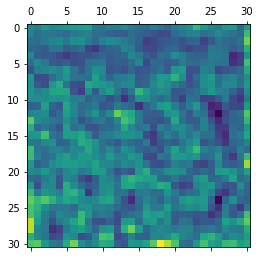

In [65]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((31,31))
plt.matshow(heatmap)
plt.show()

In [66]:
INTENSITY = 0.5

img1=cv2.imread("0014img.tif")
img1 = cv2.resize(img1,(31,31))
#heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
img1 = heatmap * INTENSITY + img1
img1 = cv2. resize(img1,(140,140))
cv2.imwrite('lol.png', img1) 

True

## Features Visualisation Grad Class Activation Maps (Heatmap) Part-2

In [ ]:
def preprocess_image(img_path, model=None, rescale=255, resize=(190,314)):
    
    from keras.preprocessing.image import img_to_array, load_img
    import cv2
    import numpy as np

    assert type(img_path) == str, "Image path must be a string"
    assert (
        type(rescale) == int or type(rescale) == float
    ), "Rescale factor must be either a float or int"
    assert (
        type(resize) == tuple and len(resize) == 2
    ), "Resize target must be a tuple with two elements"

    img = load_img(img_path)
    img = img_to_array(img)
    img = img / float(rescale)
    img = cv2.resize(img, resize)
    if model != None:
        if len(model.input_shape) == 4:
            img = np.expand_dims(img, axis=0)

    return img

In [ ]:
from keract import display_activations
from keract import get_activations
import cv2

img_path="0047img.tif"
x = preprocess_image(img_path=img_path,model=model,resize=(190,314))
# Generate the activations 
activations = get_activations(model, x)
#display_activations(activations, save=False)

## Feature Maps

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

In [ ]:
model = model
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[-1].output)

img = load_img('3182img.tif', target_size=(190,314))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=1)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :,ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show()

## CapsuleNet

In [ ]:
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator

def CapsNet(input_shape, n_class, routings):

    x = layers.Input(shape=input_shape)

   # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=5, padding='valid', activation='relu', name='conv1')(x)

   # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

   # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
    name='digitcaps')(primarycaps)

   # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
   # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

   # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y]) # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps) # Mask using the capsule with maximal length. For prediction

   # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

   # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])

   # manipulate model
    noise = layers.Input(shape=(n_class, 16))
    noised_digitcaps = layers.Add()([digitcaps, noise])
    masked_noised_y = Mask()([noised_digitcaps, y])
    manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    return train_model, eval_model, manipulate_model


def margin_loss(y_true, y_pred):

    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
    0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [ ]:
model, eval_model, manipulate_model = CapsNet(input_shape=(190,252,3),n_class=24916,routings=3)
# compile the model
model.compile(optimizer=optimizers.Adam(lr=0.001),
loss=[margin_loss, 'mse'],
loss_weights=[1., 0.392],
metrics={'capsnet': 'accuracy'})
model.summary()

In [ ]:
def train_generator(x, y, batch_size, shift_fraction=0.1):
    train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
    height_shift_range=shift_fraction) # shift up to 2 pixel for MNIST
    generator = train_datagen.flow(x, y, batch_size=batch_size)
    while 1:
    x_batch, y_batch = generator.next()
    yield ([x_batch, y_batch], [y_batch, x_batch])

# Training with data augmentation. If shift_fraction=0., also no augmentation.abs
    trained_model3 = model.fit(generator=train_generator(trainX, trainY, 1000, 0.1),
    steps_per_epoch=int(trainY.shape[0] / 1000),
    epochs=1)

## Weighted Loss

In [ ]:
def compute_class_freqs(labels):

    N = labels.shape[0]
    positive_frequencies = np.sum(labels, axis=0) / labels.shape[0]
    negative_frequencies = 1 - positive_frequencies
    return positive_frequencies, negative_frequencies

In [ ]:
from keras import backend as K
@tf.autograph.experimental.do_not_convert
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):

    def weighted_loss(y_true, y_pred):

        # initialize loss to zero
        loss = 0.0
        
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += -(K.mean( pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + epsilon) + \
                                neg_weights[i] * (1 - y_true[:,i]) * K.log(1 - y_pred[:,i] + epsilon), axis = 0))
        return loss
    
        ### END CODE HERE ###
    return weighted_loss

In [ ]:
freq_pos, freq_neg = compute_class_freqs(trainY1)

pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

## Focal Loss

In [ ]:
from keras import backend as K

def focal_loss(y_true, y_pred):
    gamma,alpha = 2.0,0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

In [ ]:
import cv2
img=cv2.imread('lol.jpg',0)
cv2.imshow('image',img)
cv2.waitkey(0)
cv2.destroyAllWindows()

In [ ]:
i=0;
for i in model.layers:
    i=i+1;
    print(i)

In [49]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140, 140, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 69, 69, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 69, 69, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 69, 69, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________